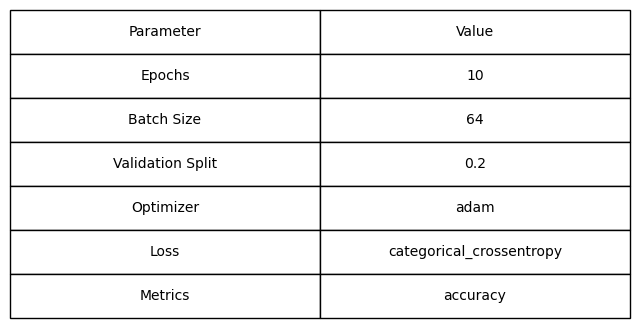

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)             

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras import backend as K

############################ Parameters  ####################################################
epochs = 10
batch_size = 64
validation_split = 0.2
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = 'accuracy'
#############################################################################################

# Display parameters in a table
param_table_data = [
    ("Epochs", epochs),
    ("Batch Size", batch_size),
    ("Validation Split", validation_split),
    ("Optimizer", optimizer),
    ("Loss", loss),
    ("Metrics", metrics)
]

param_table_headers = ["Parameter", "Value"]

plt.figure(figsize=(8, 4))
plt.table(cellText=param_table_data, colLabels=param_table_headers, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
plt.axis('off')
plt.show()

# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer, loss, metrics)

# Model architecture
model.summary()

# Train the model and capture history for plotting
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[reduce_lr])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Make predictions on new data
predictions = model.predict(test_images[:5])
print('Predictions:', predictions.argmax(axis=1))
print('True labels:', test_labels[:5].argmax(axis=1))

# Plot confusion matrix
test_predictions = model.predict(test_images)
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(10))
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')

# Visualize some sample predictions
sample_indices = np.random.choice(len(test_images), 5, replace=False)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]

sample_predictions = model.predict(sample_images)
sample_predictions_labels = sample_predictions.argmax(axis=1)
sample_true_labels = sample_labels.argmax(axis=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {sample_predictions_labels[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis('off')

# Plot learning rate
plt.figure(figsize=(8, 4))
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

# Visualize filters from the first convolutional layer
layer_outputs = [layer.output for layer in model.layers[:3]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Select an image from the test set
img = test_images[0]
img = np.expand_dims(img, axis=0)

# Get activations of the first convolutional layer
activations = activation_model.predict(img)

# Plot filters
plt.figure(figsize=(12, 4))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations[0][0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Filters from the First Convolutional Layer')

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(history.history['accuracy'], history.history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(history.history['loss'], bins=20, label='Training Loss')
plt.hist(history.history['val_loss'], bins=20, label='Validation Loss', alpha=0.7)
plt.title('Distribution of Training and Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()

# Bubble chart
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))
plt.scatter(epochs_range, history.history['accuracy'], s=np.array(history.history['lr']) * 5000, c='red', alpha=0.5, label='Accuracy')
plt.title('Accuracy and Learning Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Area chart
plt.figure(figsize=(10, 5))
plt.fill_between(epochs_range, history.history['accuracy'], history.history['val_accuracy'], color='skyblue', alpha=0.4, label='Accuracy Area')
plt.title('Accuracy Over Epochs with Validation Range')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Spline chart
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
